<a href="https://colab.research.google.com/github/lollipop6370/ML2021/blob/main/hw12_a_c_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package And Building Environment

In [1]:
!apt update
!apt install python3-opengl xvfb -y
!pip uninstall box2d box2d-py -y
!pip install swig
!pip install box2d-py==2.3.8
!pip install gymnasium[box2d] --no-deps
!pip install pyvirtualdisplay tqdm numpy torch

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
36 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [3]:
seed = 543 # Do not change this
def fix(env, seed):
  obs, info = env.reset(seed=seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [4]:
%%capture
import gymnasium as gym
import random
import numpy as np

env = gym.make('LunarLander-v3', render_mode="rgb_array")

fix(env, seed)

import time
start = time.time()

In [5]:
!pip freeze

absl-py==1.4.0
accelerate==1.8.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.23.0.39.50
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.8.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.5.0
bokeh==3.7.3
Bottleneck==1.4.2
box2d-py==2.3.8
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.6.15
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.1
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake=

# 1. Building Actor And Critic Network

# Actor

In [6]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 4),
            nn.Softmax(dim=-1)
        )

    def forward(self, observation):
        action = self.net(observation)
        return action

# Critic

In [7]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, observation):
        reward = self.net(observation)
        return reward

# 2. Building AI Agent


In [8]:
class Agent():
    def __init__(self):
        # 1. create actor and critic
        self.actor = Actor()
        self.critic = Critic()

        # 2. determined optimizer
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=0.001)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=0.001)

    # 3. sampling a action
    def sample(self, observation):
        observation_tensor = torch.tensor(observation, dtype=torch.float32)
        action_prob = self.actor(observation_tensor)
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        entropy = action_dist.entropy()
        return action.item(), log_prob, entropy

    # 4. learning
    def learn(self, observations, log_probs, rewards, entropys):

        # change data type to tensor
        observations_tensor = torch.tensor(observations, dtype=torch.float32)
        log_probs_tensor = torch.stack(log_probs)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        entropys_tensor = torch.stack(entropys)

        # critic upadte
        # goal: make the predict from critic close to reward as soon as posible.
        value = self.critic(observations_tensor).squeeze()
        loss_critic = F.mse_loss(value, rewards_tensor)
        self.optimizer_critic.zero_grad()
        loss_critic.backward()
        self.optimizer_critic.step()

        # actor update
        # goal: make the better action probability up.
        advantage = (rewards_tensor - value).detach()
        # normalization
        advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
        loss_actor = - (advantage * log_probs_tensor).sum() - 0.01 * entropys_tensor.sum()
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        self.optimizer_actor.step()

    # 5. save module
    def save(self, PATH):
        dictionary = {
            "actor": {
                "network": self.actor.state_dict(),
                "optimizer": self.optimizer_actor.state_dict()
            },
            "critic": {
                "network": self.critic.state_dict(),
                "optimizer": self.optimizer_critic.state_dict()
            }
        }
        torch.save(dictionary, PATH)

    # 6. load module
    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.actor.load_state_dict(checkpoint["actor"]["network"])
        self.optimizer_actor.load_state_dict(checkpoint["actor"]["optimizer"])
        self.critic.load_state_dict(checkpoint["critic"]["network"])
        self.optimizer_critic.load_state_dict(checkpoint["critic"]["optimizer"])

# 3. Training

# create instant

In [9]:
agent = Agent()

# train

In [10]:
agent.actor.train()
agent.critic.train()
EPISODE_PER_BATCH = 8
NUM_BATCH = 1000
GAMMA = 0.99

avg_rewards_per_batch = []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    # data for learning
    observations, log_probs, rewards, entropys = [], [], [], []
    # real reward of every action from environmant
    real_rewards_per_episode = []

    #
    for episode in range(EPISODE_PER_BATCH):
        # collect data

        observation, _ = env.reset(seed=seed)
        reward_episode = []
        # excute one episode
        while True:
            # keep going and record observation, log_prob, reward.
            observations.append(observation)
            action, log_prob, entropy = agent.sample(observation)
            log_probs.append(log_prob)
            entropys.append(entropy)
            observation, reward, terminated, truncated, _ = env.step(action)
            reward_episode.append(reward)
            done = terminated or truncated

            # if this episode is done, discount reward
            if done:
                # summation real score for record
                real_rewards_per_episode.append(sum(reward_episode))

                # calculate discount reward by algorithm
                reward_discount = 0
                reward_total = []
                for r in reversed(reward_episode):
                    reward_discount = r + reward_discount * GAMMA
                    reward_total.insert(0, reward_discount)
                rewards.extend(reward_total)
                break

    print(f"batch reward mean per episode = ",sum(real_rewards_per_episode) / len(real_rewards_per_episode))
    avg_rewards_per_batch.append(sum(real_rewards_per_episode) / len(real_rewards_per_episode))

    # train agent

    agent.learn(observations, log_probs, rewards, entropys)

  0%|          | 0/1000 [00:00<?, ?it/s]

batch reward mean per episode =  -88.6751908215533


/tmp/ipython-input-8-439028846.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  observations_tensor = torch.tensor(observations, dtype=torch.float32)


batch reward mean per episode =  -76.20649033439003
batch reward mean per episode =  -116.71868159083013
batch reward mean per episode =  -75.37297994989639
batch reward mean per episode =  -62.31775239001554
batch reward mean per episode =  -76.76303948635416
batch reward mean per episode =  -94.96731380741734
batch reward mean per episode =  -66.46815017919587
batch reward mean per episode =  -80.44138354562726
batch reward mean per episode =  -80.65383981801111
batch reward mean per episode =  -53.0429659252346
batch reward mean per episode =  -90.81400456865087
batch reward mean per episode =  -67.54255319559579
batch reward mean per episode =  -49.8908274162757
batch reward mean per episode =  -67.65367184755102
batch reward mean per episode =  -80.62643730402513
batch reward mean per episode =  -63.28932747242192
batch reward mean per episode =  -59.46514929938493
batch reward mean per episode =  -85.62640271809103
batch reward mean per episode =  -57.90419224796772
batch reward 

# training result

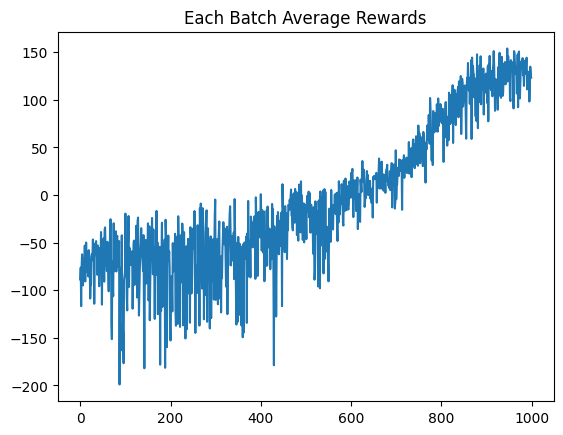

In [11]:
end = time.time()
plt.plot(avg_rewards_per_batch)
plt.title("Each Batch Average Rewards")
plt.show()

# Test

episode finished ! reward =  116.1397227585204
lenght of actions =  1000


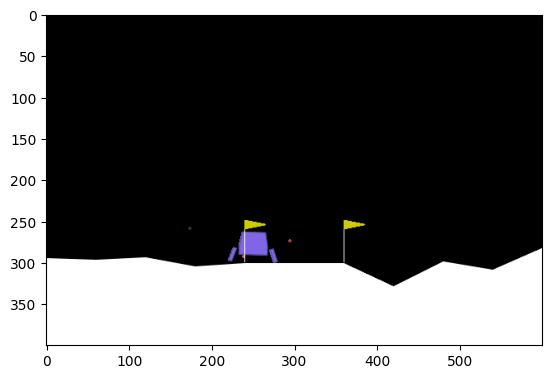

In [13]:
fix(env, seed)
agent.actor.eval()
agent.critic.eval()
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_lists = []
for i in range(NUM_OF_TEST):
    observation, _ = env.reset(seed=seed)

    img = plt.imshow(env.render())

    rewards = 0
    action_list = []
    while True:
        action, log_prob, _ = agent.sample(observation)
        observation, reward, termination, truncated, _ = env.step(action)
        rewards += reward
        action_list.append(action)

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

        done = termination or truncated
        if done:
            test_total_reward.append(rewards)
            action_lists.append(action_list)
            print(f"episode finished ! reward = ", rewards)
            print(f"lenght of actions = ", len(action_list))
            break

In [14]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 134.45


Action list 的長相

In [15]:
print("Action list looks like ", action_lists)
print("Action list's shape looks like ", len(action_lists))

Action list looks like  [[0, 2, 2, 2, 2, 0, 1, 2, 3, 2, 2, 2, 3, 2, 3, 2, 0, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 1, 3, 2, 3, 2, 1, 1, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 1, 2, 3, 2, 2, 3, 2, 0, 3, 2, 3, 3, 2, 2, 1, 2, 2, 2, 3, 2, 2, 3, 1, 2, 2, 3, 1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 3, 1, 2, 3, 2, 0, 2, 2, 3, 3, 2, 1, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 0, 2, 2, 3, 0, 3, 2, 2, 3, 2, 0, 2, 2, 3, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 3, 1, 3, 0, 3, 2, 1, 1, 3, 2, 2, 2, 2, 2, 0, 3, 1, 3, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 1, 1, 0, 3, 3, 1, 3, 3, 0, 3, 0, 0, 0, 3, 3, 1, 3, 3, 0, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 1, 0, 3, 3, 1, 3, 3, 0, 3, 3, 0, 3, 0, 2, 3, 0, 3, 3, 0, 0, 3, 1, 3, 0, 3, 0, 3, 3, 3, 1, 3, 1, 0, 0, 1, 0, 0, 0, 3, 1, 3, 3, 0, 0, 1, 0, 1, 0, 0, 3, 3, 0, 0, 1, 3, 0, 0, 3, 3, 3, 1, 3, 3, 0, 2, 0, 3, 0, 0, 1, 1, 3, 3, 3, 0, 3, 0, 3, 3,

Action 的分布

In [16]:
distribution = {}
for action_list in action_lists:
    for action in action_list:
        if action not in distribution.keys():
            distribution[action] = 1
        else:
            distribution[action] += 1
print(distribution)

{0: 1577, 2: 730, 1: 1000, 3: 1693}


# sever test

Your reward is : 132.68
Your reward is : 139.04
Your reward is : 139.57
Your reward is : 144.83
Your reward is : 116.14


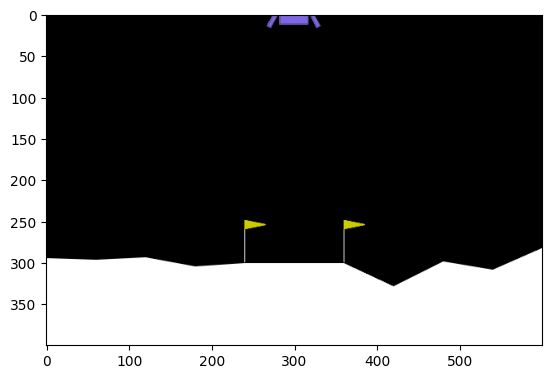

In [17]:
seed = 543 #到時候測試的seed 請不要更改
fix(env, seed)

agent.actor.eval()  # 測試前先將 network 切換為 evaluation 模式
agent.critic.eval()

test_total_reward = []
for actions in action_lists:
  state = env.reset(seed=seed)
  img = plt.imshow(env.render())

  total_reward = 0

  done = False
  # while not done:
  done_count = 0
  for action in actions:
      # action, _ = agent1.sample(state)
      state, reward, terminated, truncated, _ = env.step(action)
      done_count += 1
      total_reward += reward
      done = terminated or truncated
      if done:

        break
    #   img.set_data(env.render(mode='rgb_array'))
    #   display.display(plt.gcf())
    #   display.clear_output(wait=True)
  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

In [18]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 134.45
